In [1]:
import pandas as pd
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
import string
import logging
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
with open('./tokenized_rest_reviews.pkl', 'rb') as f:
    rests = pickle.load(f)

Below im creating a list of unique words in the tokenized restaurant reviews to create our word dictionary for our custom Word2Vec model

In [3]:
words = []
for text in rests:
    for word in text:
        words.append(word)

words = set(words)

In [4]:
len(words)

53980

Creating our final word dictionary and then casting it to a dataframe for modeling

In [5]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in rests:
    sentences.append(sentence)
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [6]:
df_word = pd.DataFrame(data, columns = ['input', 'label'])

In [7]:
df_word.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19416266 entries, 0 to 19416265
Data columns (total 2 columns):
input    object
label    object
dtypes: object(2)
memory usage: 296.3+ MB


In [8]:
df_word.head()

,input,label
0,lobster,tacos
1,lobster,must
2,tacos,lobster
3,tacos,must
4,tacos,they


This was crashing my computer with the larger amount of data so I subset the actual words dataframe to run our Tensorflow Word2Vec model on

In [9]:
df_word_subset = df_word.sample(n=10000)

Custom Tensorflow Word2Vec model using 2 dimensional embedding so we can visualize it on a graph.

In [10]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df_word_subset['input'], df_word_subset['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.sigmoid(tf.add(tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.AdamOptimizer(0.05).minimize(loss)

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 10
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 1 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  0.7349355
iteration 1 loss is :  0.6722032
iteration 2 loss is :  0.61769754
iteration 3 loss is :  0.5698149
iteration 4 loss is :  0.5268452
iteration 5 loss is :  0.48746964
iteration 6 loss is :  0.45095766
iteration 7 loss is :  0.41696066
iteration 8 loss is :  0.38527852
iteration 9 loss is :  0.35575312


In [12]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[ 1.398059    1.2120095 ]
 [-1.4732167   0.2914021 ]
 [ 2.194938   -0.33630392]
 ...
 [-0.49540856  1.1928993 ]
 [ 0.51610184  0.5891995 ]
 [ 0.7445253  -1.7645695 ]]


In [13]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df.head()

,word,x1,x2
0,lunchboxes,1.398059,1.212010
1,palomino,-1.473217,0.291402
2,thug,2.194938,-0.336304
3,unpleasing,1.789593,-0.328312
4,trainee,0.713747,0.939889


Below is a very rough graph of our word embddings graphed to see which are closesnt to one another. Ths is one way of visaulizng the cosine similarity which is a key feature of Word2Vec

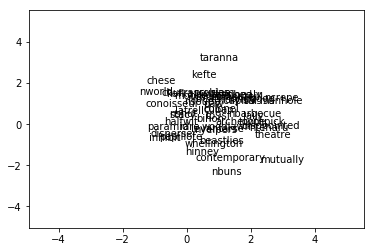

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'][100:150], w2v_df['x1'][100:150], w2v_df['x2'][100:150]):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 

plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (15,15)

plt.show()


### Gensim Word2Vec Model
I am instantiating a basic Word2Vec model to get similar words for positive and negative terms I know from my domain knowledge as a chef. This could be very useful for restaurant and food industry managers who may not have the same perspective on the reviews and words.

In [15]:
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = Word2Vec(rests, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

Below I am using the most_similar function of the Word2Vec model to see how the algorithim classifies certain words together

In [35]:
w2v_model.most_similar("bartender")

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('server', 0.5890544056892395),
 ('waitress', 0.5715939998626709),
 ('drink', 0.5694446563720703),
 ('nbartender', 0.5086668729782104),
 ('doorman', 0.5043038725852966),
 ('barstool', 0.4997553825378418),
 ('waitstaff', 0.49140769243240356),
 ('mixologist', 0.49071356654167175),
 ('brunette', 0.48748400807380676),
 ('blonde', 0.48316240310668945)]

In [30]:
w2v_model.most_similar("italian")

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pasta', 0.6212253570556641),
 ('italy', 0.6182194948196411),
 ('lasagna', 0.6118807792663574),
 ('spaghetti', 0.5929734110832214),
 ('marinara', 0.5558619499206543),
 ('penne', 0.5501000881195068),
 ('amore', 0.5473662614822388),
 ('italians', 0.5422017574310303),
 ('pomodoro', 0.5409417748451233),
 ('mario', 0.5361398458480835)]

In [36]:
w2v_model.most_similar("tequila")

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('margarita', 0.7203062176704407),
 ('reposado', 0.6261481642723083),
 ('mezcal', 0.5827651023864746),
 ('modelo', 0.5806456804275513),
 ('equis', 0.5416572093963623),
 ('eldorao', 0.5196254849433899),
 ('alcohol', 0.504309892654419),
 ('cuervo', 0.5028544068336487),
 ('mojito', 0.5002380609512329),
 ('cerveza', 0.4908977746963501)]

In [32]:
w2v_model.most_similar("pizza")

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pepperoni', 0.7645581960678101),
 ('crust', 0.6806366443634033),
 ('margherita', 0.5777288675308228),
 ('italia', 0.5755177736282349),
 ('calzones', 0.5744336247444153),
 ('prezzo', 0.571464478969574),
 ('usati', 0.5710490345954895),
 ('pizzeria', 0.5668579339981079),
 ('pepperonis', 0.5561654567718506),
 ('neapolitan', 0.5524401664733887)]

In [33]:
w2v_model.most_similar("salty")

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bland', 0.6283677816390991),
 ('taste', 0.6253387331962585),
 ('thick', 0.5589181780815125),
 ('dilute', 0.5479187965393066),
 ('greasy', 0.5362646579742432),
 ('swim', 0.5258899927139282),
 ('watery', 0.5238806009292603),
 ('boil', 0.5220019817352295),
 ('drench', 0.5189940929412842),
 ('chewy', 0.5184339284896851)]

Below I am using dictionary comprehension to do the task above but on multiple words at once, we dont get the score related to it but thats fine for our purposes.

In [16]:
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=10)]
                  for search_term in ['food', 'service', 'ambiance', 'clean', 'dirty', 'wait', 'manager']}
similar_words

/Users/jonathanbeatty/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'food': ['grocer',
  'section',
  'silken',
  'produce',
  'meat',
  'fishmonger',
  'exotic',
  'kind',
  'uncrammed',
  'rambutan'],
 'service': ['staff',
  'nservice',
  'waitstaff',
  'churi',
  'server',
  'earlgrey',
  'experience',
  'daniela',
  'nserver',
  'waiter'],
 'ambiance': ['atmosphere',
  'ambience',
  'set',
  'decor',
  'environment',
  'classy',
  'romantic',
  'elegant',
  'stuffy',
  'ambient'],
 'clean': ['spotless',
  'dirty',
  'nclean',
  'cleanliness',
  'bathroom',
  'spacious',
  'restroom',
  'urinal',
  'unisex',
  'binary'],
 'dirty': ['filthy',
  'clean',
  'unhygienic',
  'fingerprint',
  'wipe',
  'napkin',
  'spill',
  'trash',
  'unsanitary',
  'fingernail'],
 'wait': ['minute',
  'ready',
  'finally',
  'sit',
  'arrive',
  'take',
  'acknowledge',
  'table',
  'angrily',
  'stand'],
 'manager': ['manger',
  'apologize',
  'apology',
  'rudely',
  'situation',
  'management',
  'response',
  'contact',
  'profusely',
  'apologetic']}

In [34]:
similar_words_1 = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=10)]
                  for search_term in ['special', 'bath', 'chef','salty', 'manager', 'disgust', 'reservation']}
similar_words_1

{'special': ['fuscilli',
  'spectacular',
  'extraordinary',
  'ordinary',
  'simian',
  'arabiate',
  'bundt',
  'towell',
  'persuasian',
  'incompetant'],
 'bath': ['sandalwood',
  'nymph',
  'petal',
  'satiny',
  'melka',
  'inexplicable',
  'naccepted',
  'squeak',
  'gorgeous',
  'stratum'],
 'chef': ['master',
  'mughal',
  'entertain',
  'scuplted',
  'busgirl',
  'benihana',
  'skelton',
  'handrolls',
  'omakase',
  'teppanyaki'],
 'salty': ['bland',
  'taste',
  'thick',
  'dilute',
  'greasy',
  'swim',
  'watery',
  'boil',
  'drench',
  'chewy'],
 'manager': ['manger',
  'apologize',
  'apology',
  'rudely',
  'situation',
  'management',
  'response',
  'contact',
  'profusely',
  'apologetic'],
 'disgust': ['gross',
  'nasty',
  'awful',
  'terrible',
  'throw',
  'horrible',
  'unhygienic',
  'vomit',
  'rotten',
  'trash'],
 'reservation': ['advance',
  'resos',
  'book',
  'reserve',
  'hostess',
  'party',
  'early',
  'opentable',
  'valentine',
  'ahead']}

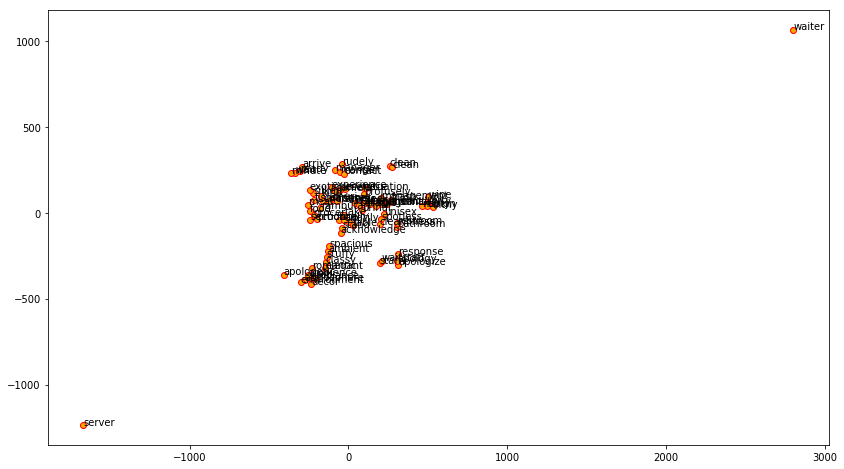

In [18]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Vader Sentiment Analysis on Word2Vec
I wanted to instantiate a VADER analysis on the Word2Vec vectorizer to see any differences between it and tf-idf vectorizer.

In [19]:
sia = SentimentIntensityAnalyzer()

dicts = []

for word in w2v_df['word']:
    scores = sia.polarity_scores(word)
    scores['words'] = word
    dicts.append(scores)

df_vader = pd.DataFrame(dicts)

df_vader.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53980 entries, 0 to 53979
Data columns (total 5 columns):
compound    53980 non-null float64
neg         53980 non-null float64
neu         53980 non-null float64
pos         53980 non-null float64
words       53980 non-null object
dtypes: float64(4), object(1)
memory usage: 2.1+ MB


In [20]:
df_vader.head(20)

,compound,neg,neu,pos,words
0,0.0000,0.0,1.0,0.0,lunchboxes
1,0.0000,0.0,1.0,0.0,palomino
2,0.0000,0.0,1.0,0.0,thug
3,0.0000,0.0,1.0,0.0,unpleasing
4,0.0000,0.0,1.0,0.0,trainee
5,0.0000,0.0,1.0,0.0,illiterate
6,0.0000,0.0,1.0,0.0,doozy
7,0.0000,0.0,1.0,0.0,integratging
8,-0.5423,1.0,0.0,0.0,bastard
9,0.0000,0.0,1.0,0.0,vacillate


In [21]:
df_sentiment_w2v = pd.concat([df_vader, w2v_df], axis = 1)

In [22]:
df_sentiment_w2v.head()

,compound,neg,neu,pos,words,word,x1,x2
0,0.0,0.0,1.0,0.0,lunchboxes,lunchboxes,1.398059,1.212010
1,0.0,0.0,1.0,0.0,palomino,palomino,-1.473217,0.291402
2,0.0,0.0,1.0,0.0,thug,thug,2.194938,-0.336304
3,0.0,0.0,1.0,0.0,unpleasing,unpleasing,1.789593,-0.328312
4,0.0,0.0,1.0,0.0,trainee,trainee,0.713747,0.939889


In [23]:
df_sentiment_w2v = df_sentiment_w2v.drop(columns='words')

In [24]:
df_sentiment_w2v.head()

,compound,neg,neu,pos,word,x1,x2
0,0.0,0.0,1.0,0.0,lunchboxes,1.398059,1.212010
1,0.0,0.0,1.0,0.0,palomino,-1.473217,0.291402
2,0.0,0.0,1.0,0.0,thug,2.194938,-0.336304
3,0.0,0.0,1.0,0.0,unpleasing,1.789593,-0.328312
4,0.0,0.0,1.0,0.0,trainee,0.713747,0.939889


In [25]:
df_sentiment_w2v.sort_values(by='neg', ascending=False).head(20)

,compound,neg,neu,pos,word,x1,x2
7296,-0.3612,1.0,0.0,0.0,stinky,-0.391477,0.747404
52004,-0.2960,1.0,0.0,0.0,pitifully,-0.360968,0.449952
1940,-0.3400,1.0,0.0,0.0,crazy,0.670277,0.538641
21865,-0.4019,1.0,0.0,0.0,greed,0.747470,0.462238
21863,-0.3818,1.0,0.0,0.0,dump,0.035247,-1.012182
5684,-0.5106,1.0,0.0,0.0,agonizingly,-0.391601,-0.234788
18917,-0.4404,1.0,0.0,0.0,passionless,-0.817341,1.069866
29064,-0.4767,1.0,0.0,0.0,nasties,-0.083866,0.354388
45405,-0.1280,1.0,0.0,0.0,dominate,0.814346,0.341969
15614,-0.3400,1.0,0.0,0.0,uneasily,0.048606,-0.523593


In [26]:
df_sentiment_w2v.sort_values(by='pos', ascending=False).head(20)

,compound,neg,neu,pos,word,x1,x2
7183,0.0516,0.0,0.0,1.0,grey,2.030250,-0.274741
25562,0.3818,0.0,0.0,1.0,niceness,0.442054,0.883697
24147,0.2960,0.0,0.0,1.0,vital,0.841167,0.324058
26399,0.4019,0.0,0.0,1.0,laugher,-1.673892,1.170423
32618,0.4939,0.0,0.0,1.0,courage,2.847180,0.826474
24760,0.2023,0.0,0.0,1.0,fine,-0.484132,0.863264
24761,0.2960,0.0,0.0,1.0,surprisingly,0.548202,-1.186823
38817,0.4767,0.0,0.0,1.0,energize,1.501165,-0.027461
53135,0.2960,0.0,0.0,1.0,playfulness,1.721239,2.261100
41155,0.4215,0.0,0.0,1.0,TRUE,-0.213702,-1.423623


In [27]:
df_sentiment_w2v.sort_values(by='neu', ascending=False).head(20)

,compound,neg,neu,pos,word,x1,x2
0,0.0,0.0,1.0,0.0,lunchboxes,1.398059,1.212010
35606,0.0,0.0,1.0,0.0,pachinko,1.067379,0.269308
35596,0.0,0.0,1.0,0.0,lettas,1.296221,1.736362
35597,0.0,0.0,1.0,0.0,mashy,-1.336028,0.255432
35598,0.0,0.0,1.0,0.0,ronald,1.823853,2.703326
35599,0.0,0.0,1.0,0.0,appology,0.091045,0.777030
35600,0.0,0.0,1.0,0.0,face,0.238783,-0.594870
35601,0.0,0.0,1.0,0.0,huhner,-1.884475,-0.255447
35602,0.0,0.0,1.0,0.0,whoopee,-0.025519,0.510712
35603,0.0,0.0,1.0,0.0,gogos,2.088820,0.377834


In [28]:
df_sentiment_w2v.sort_values(by='compound', ascending=False).head(20)

,compound,neg,neu,pos,word,x1,x2
36995,0.6597,0.0,0.0,1.0,magnificently,1.132198,0.703060
46366,0.6486,0.0,0.0,1.0,sweetheart,0.007429,-2.154750
27401,0.6486,0.0,0.0,1.0,euphoria,0.128434,-1.024969
44626,0.6486,0.0,0.0,1.0,ecstacy,-0.282409,1.604441
28203,0.6369,0.0,0.0,1.0,glorious,1.598407,1.425128
29842,0.6369,0.0,0.0,1.0,euphoric,1.692440,-0.013281
47905,0.6369,0.0,0.0,1.0,lovingly,0.553457,0.411569
34064,0.6369,0.0,0.0,1.0,love,0.287580,0.643707
5448,0.6369,0.0,0.0,1.0,perfectly,0.400949,0.212724
22356,0.6369,0.0,0.0,1.0,best,0.930666,1.704481
